In [4]:
!nvidia-smi

Sun Feb  2 22:05:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX350         WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P0             N/A / 5001W |       0MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import os
#HOME = os.getcwd()
HOME = "d:\programing\ML&DL\MY_Work"
print("HOME:", HOME)

HOME: d:\programing\ML&DL\MY_Work


!wget, {HOME} are usually used in collab alternativly we use !curl, abslut bath in jupter notebook

In [9]:
#!mkdir -p {HOME}/data
#!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/yolo-ultralytics
!curl -o "d:\programing\ML&DL\MY_Work\yolo-ultralytics\dog.jpeg" https://media.roboflow.com/notebooks/examples/dog.jpeg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  103k  100  103k    0     0   120k      0 --:--:-- --:--:-- --:--:--  120k


In [13]:
%pip install -q supervision jupyter_bbox_widget

Note: you may need to restart the kernel to use updated packages.


In [12]:
!python.exe -m pip install --upgrade pip

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----------- ---------------------------- 0.5/1.8 MB 840.2 kB/s eta 0:00:02
   ----------- ---------------------------- 0.5/1.8 MB 840.2 kB/s eta 0:00:02
   ----------------- ---------------------- 0.8/1.8 MB 882.6 kB/s eta 0:00:02
   ---------------------- ----------------- 1.0/1.8 MB 968.5 kB/s eta 0:00:01
   ---------------------------- ----------- 1.3/1.8 MB 987.4 kB/s eta 0:00:01
   ---------------------------------- ----- 1.6/1.8 MB 1.0 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 1.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1


In [6]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

**Load model**

In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = "D:\programing\ML&DL\MY_Work\yolo-ultralytics\checkpoints\sam2.1_hiera_large.pt"
CONFIG = "D:\programing\ML&DL\MY_Work\yolo-ultralytics\configration\sam2.1_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

In [9]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

NOTE: OpenCV loads images in BGR format by default, so we convert to RGB for compatibility with the mask generator.

In [10]:
IMAGE_PATH = "d:\\programing\\ML&DL\\MY_Work\\yolo-ultralytics\\dog.jpeg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam2_result = mask_generator.generate(image_rgb)

Output format
* SAM2AutomaticMaskGenerator returns a list of masks, where each mask is a dict containing various information about the mask:

* segmentation - [np.ndarray] - the mask with (W, H) shape, and bool type
* area - [int] - the area of the mask in pixels
* bbox - [List[int]] - the boundary box of the mask in xywh format
* predicted_iou - [float] - the model's own prediction for the quality of the mask
* point_coords - [List[List[float]]] - the sampled input point that generated this mask
* stability_score - [float] - an additional measure of mask quality
* crop_box - List[int] - the crop of the image used to generate this mask in xywh format

# Results visualisation

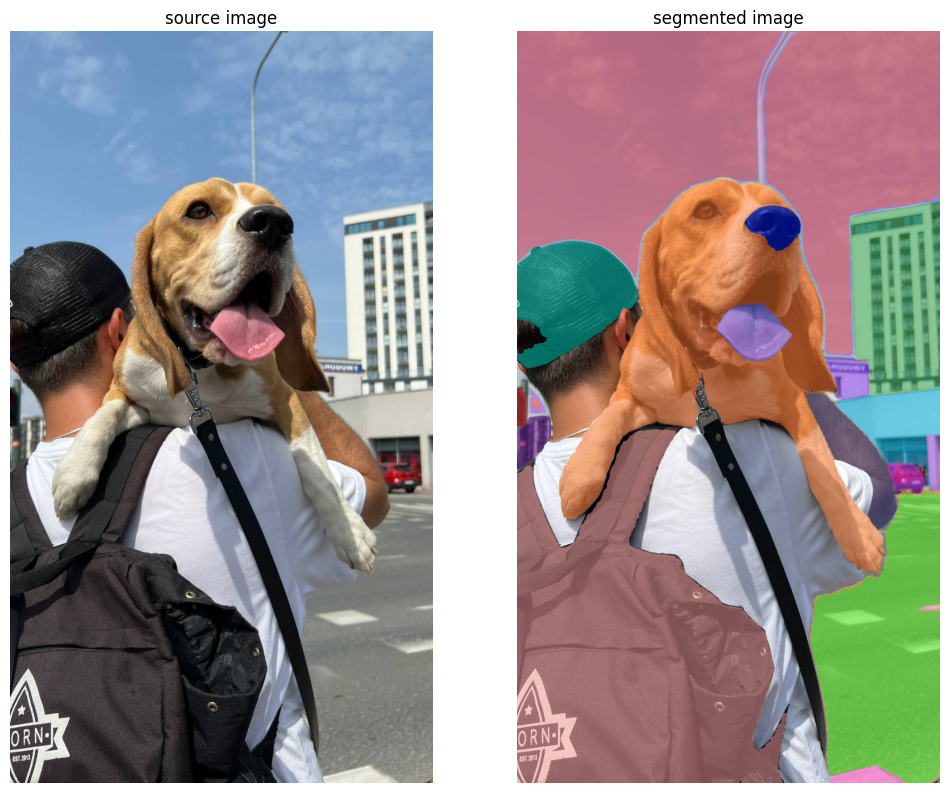

In [11]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

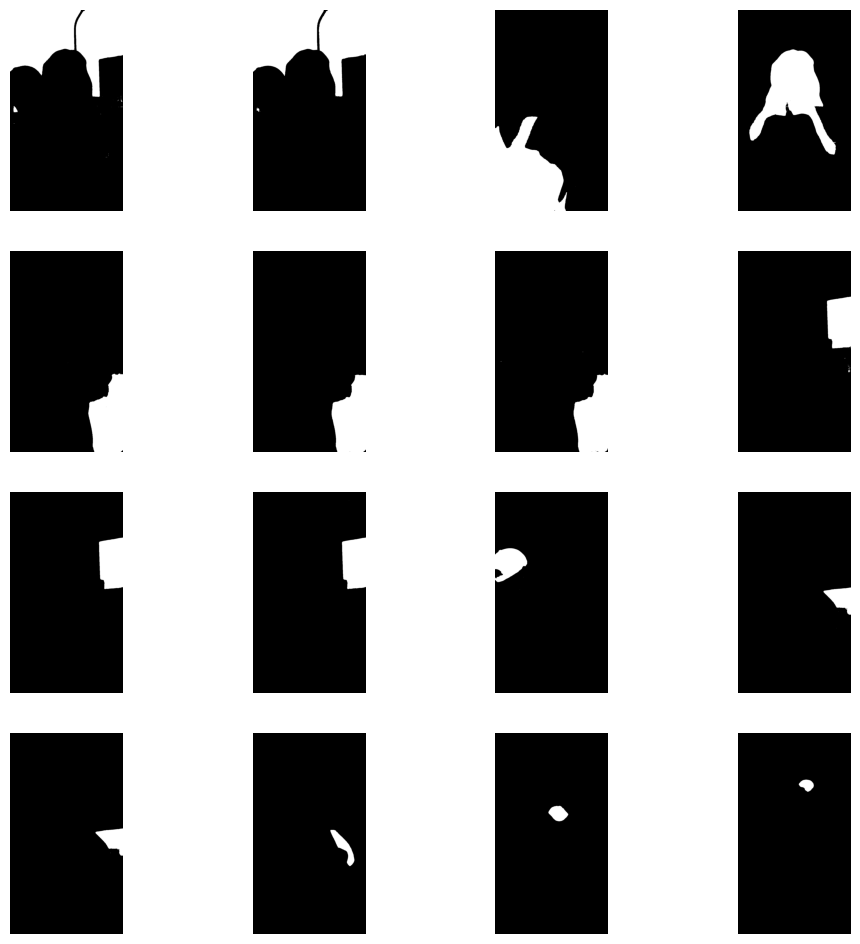

In [12]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam2_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

# Advanced automatic mask generation options
There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes.

* points_per_side [int or None] - the number of points to be sampled along one side of the image. The total number of points is points_per_side**2. If None, point_grids must provide explicit point sampling.
* points_per_batch - [int] - sets the number of points run simultaneously by the model. Higher numbers may be faster but use more GPU memory.
* pred_iou_thresh [float] - a filtering threshold in [0,1], using the model's predicted mask quality.
* stability_score_thresh - [float] - a filtering threshold in [0,1], using the stability of the mask under changes to the cutoff used to binarize the model's mask predictions.
* stability_score_offset - [float] - the amount to shift the cutoff when calculated the stability score.
* mask_threshold - [float] - threshold for binarizing the mask logits
* box_nms_thresh - [float] - the box IoU cutoff used by non-maximal suppression to filter duplicate masks.
* crop_n_layers - [int] - if >0, mask prediction will be run again on crops of the image. Sets the number of layers to run, where each layer has 2**i_layer number of image crops.
* crop_nms_thresh - [float] - the box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.
* crop_overlap_ratio - [float] - sets the degree to which crops overlap. In the first crop layer, crops will overlap by this fraction of the image length. Later layers with more crops scale down this overlap.
* crop_n_points_downscale_factor - [int] - the number of points-per-side sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
* point_grids - [List[np.ndarray] or None] - a list over explicit grids of points used for sampling, normalized to [0,1]. The nth grid in the list is used in the nth crop layer. Exclusive with points_per_side.
* min_mask_region_area - [int] - if >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area. Requires opencv.

In [13]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

In [14]:
sam2_result_2 = mask_generator_2.generate(image_rgb)

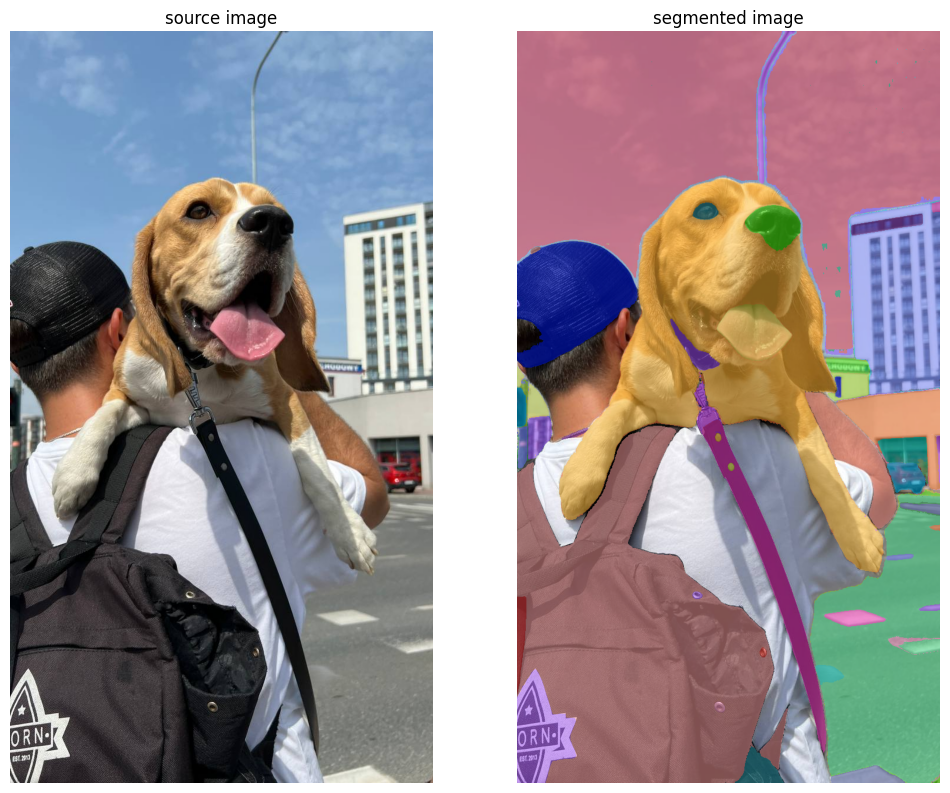

In [15]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result_2)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [17]:
predictor = SAM2ImagePredictor(sam2_model)
IMAGE_PATH = "d:\programing\ML&DL\MY_Work/yolo-ultralytics/dog.jpeg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [18]:
from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [19]:
widget.bboxes

[{'x': 62, 'y': 246, 'width': 567, 'height': 682, 'label': ''}]

In [21]:
default_box = [{'x': 62, 'y': 246, 'width': 567, 'height': 682, 'label': ''}]

boxes = widget.bboxes if widget.bboxes else default_box
boxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
])

In [22]:
predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)

# With one box as input, predictor returns masks of shape (1, H, W);
# with N boxes, it returns (N, 1, H, W).
#np.squeeze(masks): Removes single-dimensional entries from the shape of the masks array. 
# This is necessary because the shape of masks can be (N, 1, H, W) when there are multiple bounding boxes
# , and we want to convert it to (N, H, W).

#if boxes.shape[0] != 1:
#    masks = np.squeeze(masks)

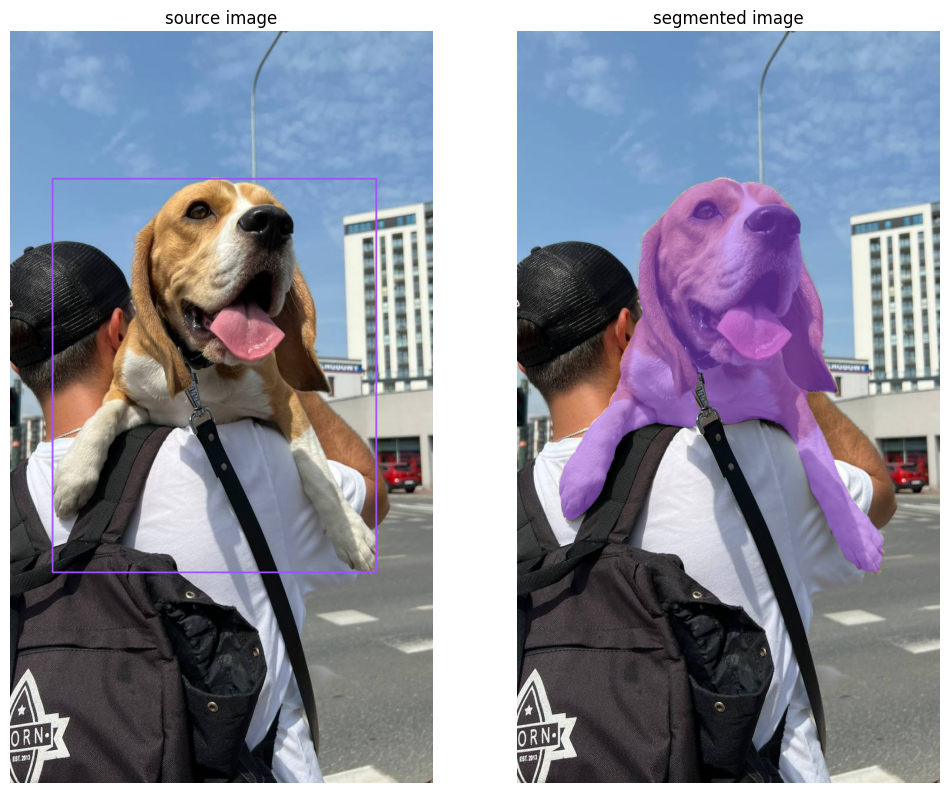

In [23]:
box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

# Segment Anything in Roboflow Universe Dataset

In [25]:
%pip install dataclasses-json

Note: you may need to restart the kernel to use updated packages.


In [26]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

In [28]:
%pip install roboflow --user

  Using cached roboflow-1.1.53-py3-none-any.whl.metadata (9.7 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
Using cached roboflow-1.1.53-py3-none-any.whl (82 kB)
Using cached idna-3.7-py3-none-any.whl (66 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.1 requires numpy<=1.24.3,>=1.22, but you have numpy 2.2.2 which is incompatible.
tensorflow-intel 2.13.1 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.


In [29]:
import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("hashira-fhxpj").project("mri-brain-tumor")
dataset = project.version(1).download("coco")

visit https://app.roboflow.com/auth-cli to get your authentication token.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MRI-BRAIN-TUMOR-1 in coco:: 100%|██████████| 85/85 [00:00<00:00, 1265.67it/s]


In [34]:
import os

DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)

In [35]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image
    in coco_data.images
]

In [36]:
CLASSES

['YES-TUMOR']

In [37]:
# set random seed to allow easy reproduction of the experiment

import random
random.seed(10)

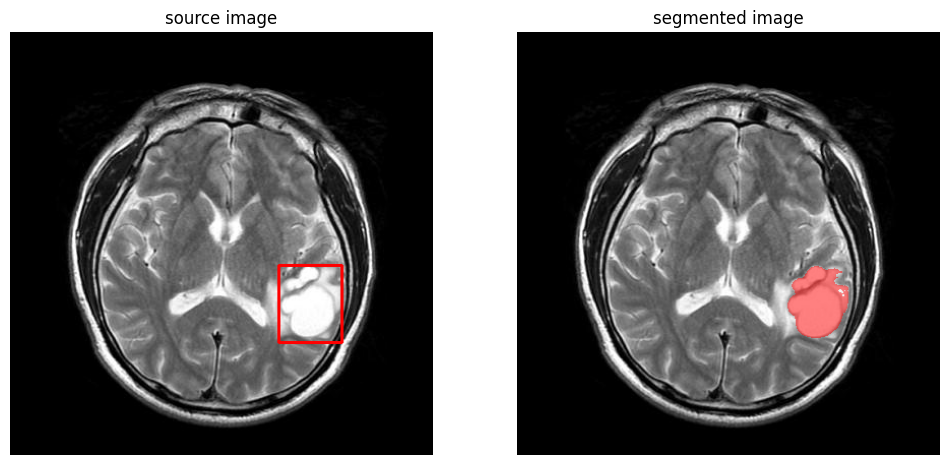

In [39]:
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# load dataset annotations
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# small hack - coco numerate classes from 1, model from 0 + we drop first redundant class from coco json
ground_truth.class_id = ground_truth.class_id - 1

# load image
image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# initiate annotator
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

# annotate ground truth
annotated_frame_ground_truth = box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth)

# run SAM inference
predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=False
)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)
detections = detections[detections.area == np.max(detections.area)]

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)